
## Introduction:

In this analysis, we will be calculating the young stars who have the best potential. We will use current data to define the age of a young player, their efficiency based on others, and other criteria. Our goal is to identify the players with the highest potential and analyze their performance in various aspects.

Let's get started!


Source:   
This work was highly inspired by this work: https://www.kaggle.com/code/vivovinco/nba-rising-stars-2022-2023

In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
import os

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [5]:
from nba_api.stats.static import players
from nba_api.stats.endpoints import playergamelog
from nba_api.stats.endpoints import playercareerstats
from nba_api.stats.endpoints import teamestimatedmetrics

#

## Fetch stats of players per match

In [6]:
def fetch_nba_player_stats(season, existing_player_ids=[]):
    nba_players = players.get_active_players()
    all_players_stats_list = []  

    for player in nba_players:
        if player['is_active'] and player['id'] not in existing_player_ids:  # only active players not in existing data
            player_id = player['id']
            try:
                gamelog = playergamelog.PlayerGameLog(player_id=player_id, season=season)
                df = gamelog.get_data_frames()[0]
                all_players_stats_list.append(df)
            except Exception as e:
                print(f"Erreur lors de la récupération des données pour le joueur {player['full_name']} (ID: {player_id}): {e}")

    all_players_stats = pd.concat(all_players_stats_list, ignore_index=True)
    return all_players_stats

In [7]:
today = datetime.now().strftime("%Y-%m-%d")

file_path_stats_per_match = f'../dataset/nba_player_stats_{today}.csv'

# Verify if dataset alrealdy exists
if os.path.exists(file_path_stats_per_match):
    existing_data = pd.read_csv(file_path_stats_per_match)
    existing_player_ids = existing_data['Game_ID'].unique()  
else:
    existing_data = pd.DataFrame()
    existing_player_ids = []

In [8]:
season = '2023-24'
player_stats = fetch_nba_player_stats(season)

C:\Users\33624\AppData\Local\Temp\ipykernel_105208\684601579.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_players_stats = pd.concat(all_players_stats_list, ignore_index=True)


In [9]:
player_stats.columns

Index(['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL',
       'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE'],
      dtype='object')

In [10]:
player_stats['GAME_DATE'] = pd.to_datetime(player_stats['GAME_DATE'], format='%b %d, %Y')

col_type = player_stats["GAME_DATE"].dtypes
print(col_type)

datetime64[ns]


In [11]:
player_stats.drop('VIDEO_AVAILABLE', axis=1, inplace=True)

### Register on disk

In [12]:
#player_stats.to_csv(file_path_stats_per_match, index=False) #the file will be overwrite if already existing 

#

## Get IDs of active players

In [13]:
def fetch_active_nba_players():
    nba_players = players.get_active_players()
    player_dict = {}

    for player in nba_players:
        player_id = player['id']
        player_name = player['full_name']
        player_dict[player_id] = player_name

    return player_dict

nba_players_dict = fetch_active_nba_players()
for player_name in nba_players_dict.values():
    print(f"{player_name}")

Precious Achiuwa
Steven Adams
Bam Adebayo
Ochai Agbaji
Santi Aldama
Nickeil Alexander-Walker
Grayson Allen
Jarrett Allen
Jose Alvarado
Kyle Anderson
Giannis Antetokounmpo
Thanasis Antetokounmpo
Cole Anthony
OG Anunoby
Ryan Arcidiacono
Deni Avdija
Deandre Ayton
Udoka Azubuike
Marvin Bagley III
Amari Bailey
Patrick Baldwin Jr.
LaMelo Ball
Lonzo Ball
Mo Bamba
Paolo Banchero
Desmond Bane
Dalano Banton
Dominick Barlow
Harrison Barnes
Scottie Barnes
RJ Barrett
Charles Bassey
Emoni Bates
Keita Bates-Diop
Nicolas Batum
Bradley Beal
Malik Beasley
MarJon Beauchamp
Charles Bediako
Davis Bertans
Patrick Beverley
Saddiq Bey
Goga Bitadze
Onuralp Bitim
Bismack Biyombo
Anthony Black
Leaky Black
Bogdan Bogdanovic
Bojan Bogdanovic
Bol Bol
Marques Bolden
Devin Booker
Brandon Boston Jr.
Chris Boucher
James Bouknight
Malaki Branham
Christian Braun
Mikal Bridges
Miles Bridges
Oshae Brissett
Malcolm Brogdon
Armoni Brooks
Dillon Brooks
Bruce Brown
Jaylen Brown
Kendall Brown
Kobe Brown
Moses Brown
Greg Brown I

#

## Get global stats of active players in 2023-24

In [14]:
def fetch_stats_players_for_2023_24(player_dict, season='2023-24'):
    all_players_stats = pd.DataFrame()
    
    for player_id, player_name in player_dict.items():
        career = playercareerstats.PlayerCareerStats(player_id=player_id)
        career_df = career.get_data_frames()[0]
        # Filtrer pour la saison 2023-24
        season_stats = career_df[career_df['SEASON_ID'] == season]
        # Ajouter le nom complet du joueur
        season_stats['full_name'] = player_name
        all_players_stats = pd.concat([all_players_stats, season_stats], ignore_index=True)
    
    # S'assurer que 'full_name' est la deuxième colonne
    cols = list(all_players_stats.columns)
    cols.insert(1, cols.pop(cols.index('full_name')))
    all_players_stats = all_players_stats.loc[:, cols]
    
    return all_players_stats

In [15]:
players_stats_2023_24 = fetch_stats_players_for_2023_24(nba_players_dict)

C:\Users\33624\AppData\Local\Temp\ipykernel_105208\2948995895.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_stats['full_name'] = player_name
C:\Users\33624\AppData\Local\Temp\ipykernel_105208\2948995895.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_stats['full_name'] = player_name
C:\Users\33624\AppData\Local\Temp\ipykernel_105208\2948995895.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [16]:
players_stats_2023_24.head()

,PLAYER_ID,full_name,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,1630173,Precious Achiuwa,2023-24,00,1610612761,TOR,24.0,25,0,437.0,...,0.571,50,86,136,44,16,12,29,40,193
1,1630173,Precious Achiuwa,2023-24,00,1610612752,NYK,24.0,19,5,416.0,...,0.750,49,65,114,13,11,17,12,36,124
2,1630173,Precious Achiuwa,2023-24,00,0,TOT,24.0,44,5,853.0,...,0.611,99,151,250,57,27,29,41,76,317
3,1628389,Bam Adebayo,2023-24,00,1610612748,MIA,26.0,42,42,1450.0,...,0.773,92,349,441,169,42,41,102,105,849
4,1630534,Ochai Agbaji,2023-24,00,1610612762,UTA,23.0,51,10,1003.0,...,0.750,35,91,126,47,27,29,34,66,274


In [17]:
players_stats_2023_24.shape

(557, 28)

In [18]:
players_stats_2023_24.drop("SEASON_ID", axis=1, inplace=True)
players_stats_2023_24.drop("LEAGUE_ID", axis=1, inplace=True)

In [19]:
players_stats_2023_24.columns

Index(['PLAYER_ID', 'full_name', 'TEAM_ID', 'TEAM_ABBREVIATION', 'PLAYER_AGE',
       'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
       'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PTS'],
      dtype='object')

### Keep only Total on season for traded players

In [20]:
def filter_players_to_tot(df):
    # Trouver les joueurs avec plusieurs entrées (équipes) dans la même saison
    multiple_teams = df[df.duplicated(subset=['PLAYER_ID'], keep=False)]
    
    # Identifier les ID des joueurs qui ont 'TOT' comme abréviation d'équipe
    players_with_tot = multiple_teams[multiple_teams['TEAM_ABBREVIATION'] == 'TOT']['PLAYER_ID'].unique()
    
    # Filtrer pour garder les lignes 'TOT' pour ces joueurs
    tot_rows = df[(df['PLAYER_ID'].isin(players_with_tot)) & (df['TEAM_ABBREVIATION'] == 'TOT')]
    
    # Filtrer pour garder les joueurs qui n'ont pas changé d'équipe (n'apparaissent pas dans 'players_with_tot')
    single_team_rows = df[~df['PLAYER_ID'].isin(players_with_tot)]
    
    # Concaténer les deux groupes de lignes
    final_df = pd.concat([tot_rows, single_team_rows], ignore_index=True)
    
    return final_df

In [21]:
players_stats_2023_24 = filter_players_to_tot(players_stats_2023_24)

In [22]:
players_stats_2023_24.head() 

,PLAYER_ID,full_name,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,FGA,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,1630173,Precious Achiuwa,0,TOT,24.0,44,5,853.0,134,283,...,0.611,99,151,250,57,27,29,41,76,317
1,1628384,OG Anunoby,0,TOT,26.0,41,41,1401.0,238,478,...,0.774,39,132,171,93,53,28,62,96,627
2,1628963,Marvin Bagley III,0,TOT,24.0,34,12,671.0,154,258,...,0.752,79,106,185,38,10,17,45,64,389
3,1629628,RJ Barrett,0,TOT,23.0,41,41,1280.0,287,610,...,0.764,34,182,216,117,21,16,75,90,793
4,201587,Nicolas Batum,0,TOT,35.0,34,27,846.0,70,135,...,0.643,42,89,131,78,23,25,21,68,193


In [23]:
players_stats_2023_24.columns

Index(['PLAYER_ID', 'full_name', 'TEAM_ID', 'TEAM_ABBREVIATION', 'PLAYER_AGE',
       'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
       'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PTS'],
      dtype='object')

In [24]:
today = datetime.now().strftime("%Y-%m-%d")

file_path_global_stats = f'../dataset/nba_player_global_stats_{today}.csv'

# Verify if dataset alrealdy exists
if os.path.exists(file_path_global_stats):
    existing_data = pd.read_csv(file_path_global_stats)
    existing_player_ids = existing_data['Game_ID'].unique()  
else:
    existing_data = pd.DataFrame()
    existing_player_ids = []


#players_stats_2023_24.to_csv(file_path_global_stats, index=False) #the file will be overwrite if already existing 

### Data Vizualisation NBA players 
The following views show player data


## 1. Analyse des Statistiques Individuelles

In [55]:
import pandas as pd
import plotly.graph_objects as go

df = players_stats_2023_24

# Création d'un dictionnaire pour mapper les abréviations aux noms complets
column_names = {
    'PLAYER_AGE': 'Age of Player',
    'GP': 'Games Played',
    'GS': 'Games Started',
    'MIN': 'Minutes Played',
    'FGM': 'Field Goals Made',
    'FGA': 'Field Goals Attempted',
    'FG_PCT': 'Field Goal Percentage',
    'FG3M': 'Three-Point Field Goals Made',
    'FG3A': 'Three-Point Field Goals Attempted',
    'FG3_PCT': 'Three-Point Field Goal Percentage',
    'FTM': 'Free Throws Made',
    'FTA': 'Free Throws Attempted',
    'FT_PCT': 'Free Throw Percentage',
    'OREB': 'Offensive Rebounds',
    'DREB': 'Defensive Rebounds',
    'REB': 'Total Rebounds',
    'AST': 'Assists',
    'STL': 'Steals',
    'BLK': 'Blocks',
    'TOV': 'Turnovers',
    'PF': 'Personal Fouls',
    'PTS': 'Total Points'
}

# Renommer les colonnes dans le DataFrame
df = df.rename(columns=column_names)

# Sélectionner uniquement les colonnes renommées pour la matrice de corrélation
numeric_df = df[list(column_names.values())]

# Calculer la matrice de corrélation
correlation_matrix = numeric_df.corr()

# Créer la heatmap avec Plotly
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,
    x=correlation_matrix.columns,
    y=correlation_matrix.index,
    colorscale='Oranges',
))

# Mise à jour de la disposition de la figure
fig.update_layout(
    title='Correlation Heatmap',
    xaxis_nticks=36,
    yaxis_nticks=36,
    xaxis_title='Features',
    yaxis_title='Features',
    height=900,
    width=900,
    template='plotly_dark'
)

# Afficher la figure
fig.show()


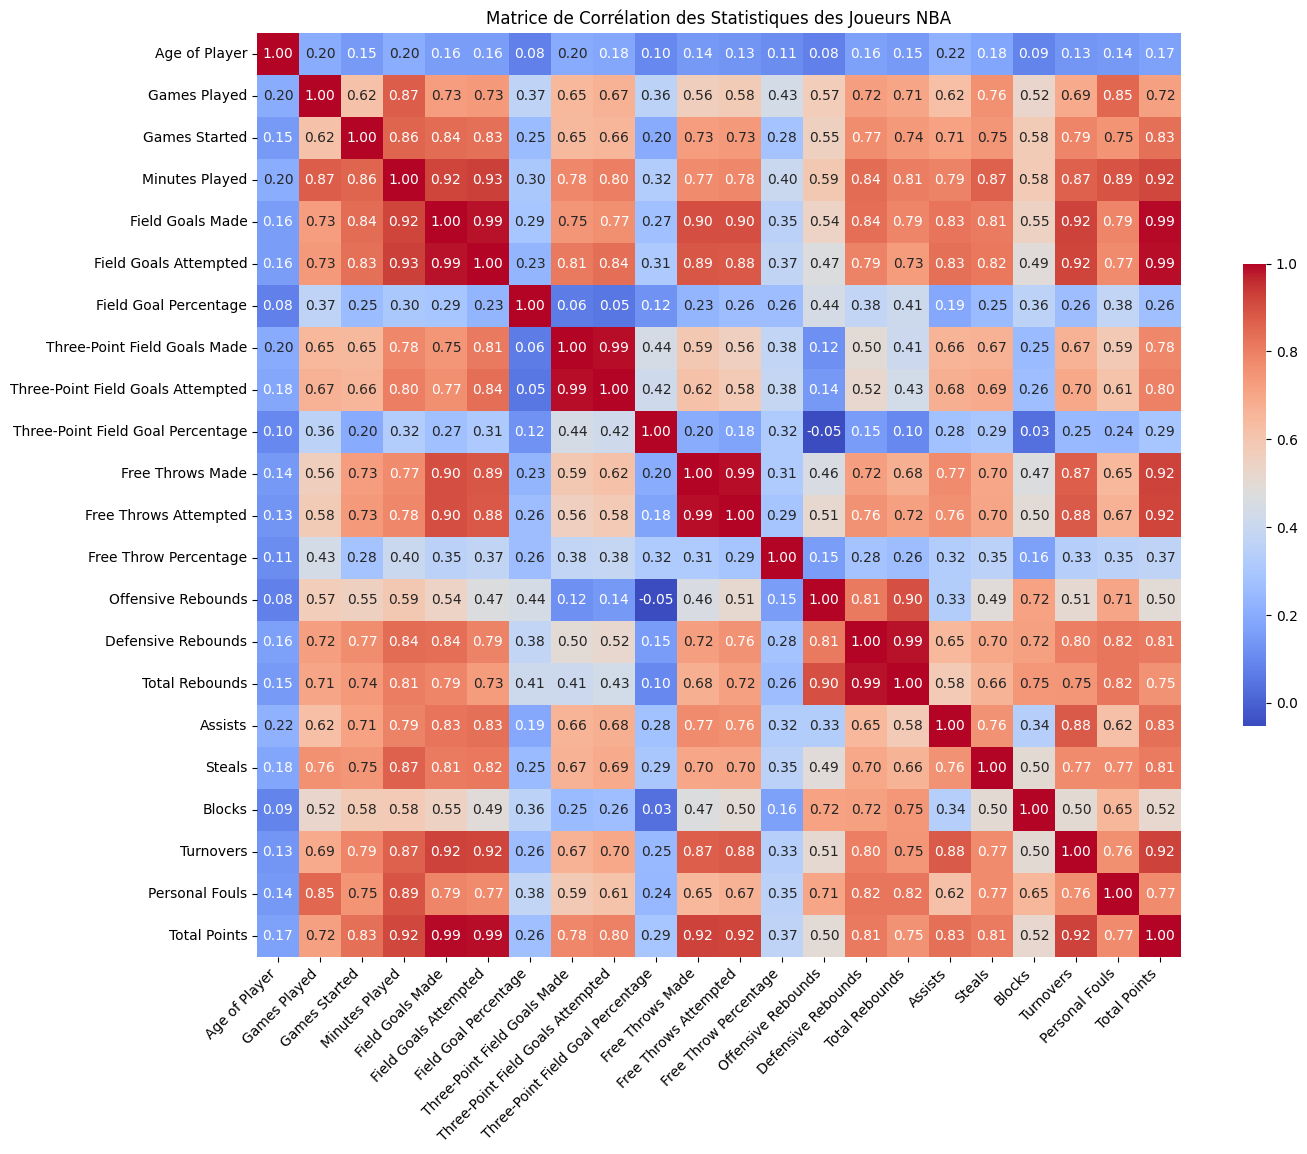

<Figure size 640x480 with 0 Axes>

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assurez-vous de charger vos données dans un DataFrame pandas
# Remplacez 'chemin/vers/votre/fichier.csv' par le chemin réel vers votre fichier de données
df = players_stats_2023_24

# Mapping des noms de colonnes de l'abréviation vers la description complète pour la clarté
column_names = {
    'PLAYER_AGE': 'Age of Player',
    'GP': 'Games Played',
    'GS': 'Games Started',
    'MIN': 'Minutes Played',
    'FGM': 'Field Goals Made',
    'FGA': 'Field Goals Attempted',
    'FG_PCT': 'Field Goal Percentage',
    'FG3M': 'Three-Point Field Goals Made',
    'FG3A': 'Three-Point Field Goals Attempted',
    'FG3_PCT': 'Three-Point Field Goal Percentage',
    'FTM': 'Free Throws Made',
    'FTA': 'Free Throws Attempted',
    'FT_PCT': 'Free Throw Percentage',
    'OREB': 'Offensive Rebounds',
    'DREB': 'Defensive Rebounds',
    'REB': 'Total Rebounds',
    'AST': 'Assists',
    'STL': 'Steals',
    'BLK': 'Blocks',
    'TOV': 'Turnovers',
    'PF': 'Personal Fouls',
    'PTS': 'Total Points'
}

# Renommer les colonnes pour plus de clarté
df.rename(columns=column_names, inplace=True)

# Sélectionner uniquement les colonnes numériques pour la matrice de corrélation
numeric_cols = list(column_names.values())
numeric_df = df[numeric_cols]

# Vérification des types de données pour s'assurer que toutes les colonnes sont numériques
numeric_df = numeric_df.apply(pd.to_numeric, errors='coerce')

# Calcul de la matrice de corrélation
correlation_matrix = numeric_df.corr()

# Utilisation de Seaborn pour créer une heatmap de la matrice de corrélation
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={'shrink': .5})

# Ajout des titres et des étiquettes pour une meilleure lisibilité
plt.title('Matrice de Corrélation des Statistiques des Joueurs NBA')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Affichage de la heatmap
plt.show()

# Si nécessaire, sauvegarde de la figure
plt.savefig('heatmap_correlation.png', bbox_inches='tight')


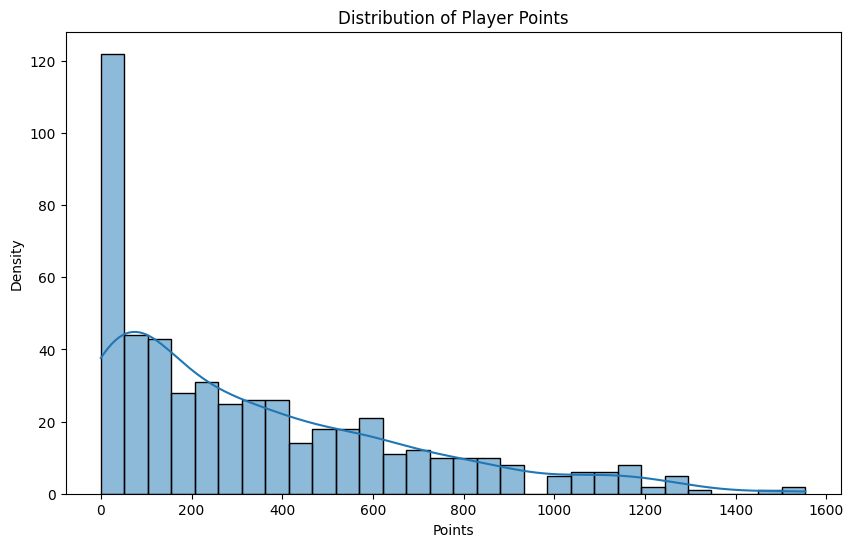

In [25]:
# Ensure that player_stats is defined and has the 'PTS' column

plt.figure(figsize=(10, 6))
sns.histplot(players_stats_2023_24['PTS'], bins=30, kde=True)  # Use histplot instead of distplot
plt.title('Distribution of Player Points')
plt.xlabel('Points')
plt.ylabel('Density')
plt.show()


C:\Users\33624\AppData\Local\Temp\ipykernel_105208\3689240870.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='PTS', y='full_name', data=top_players_by_points, palette='coolwarm')


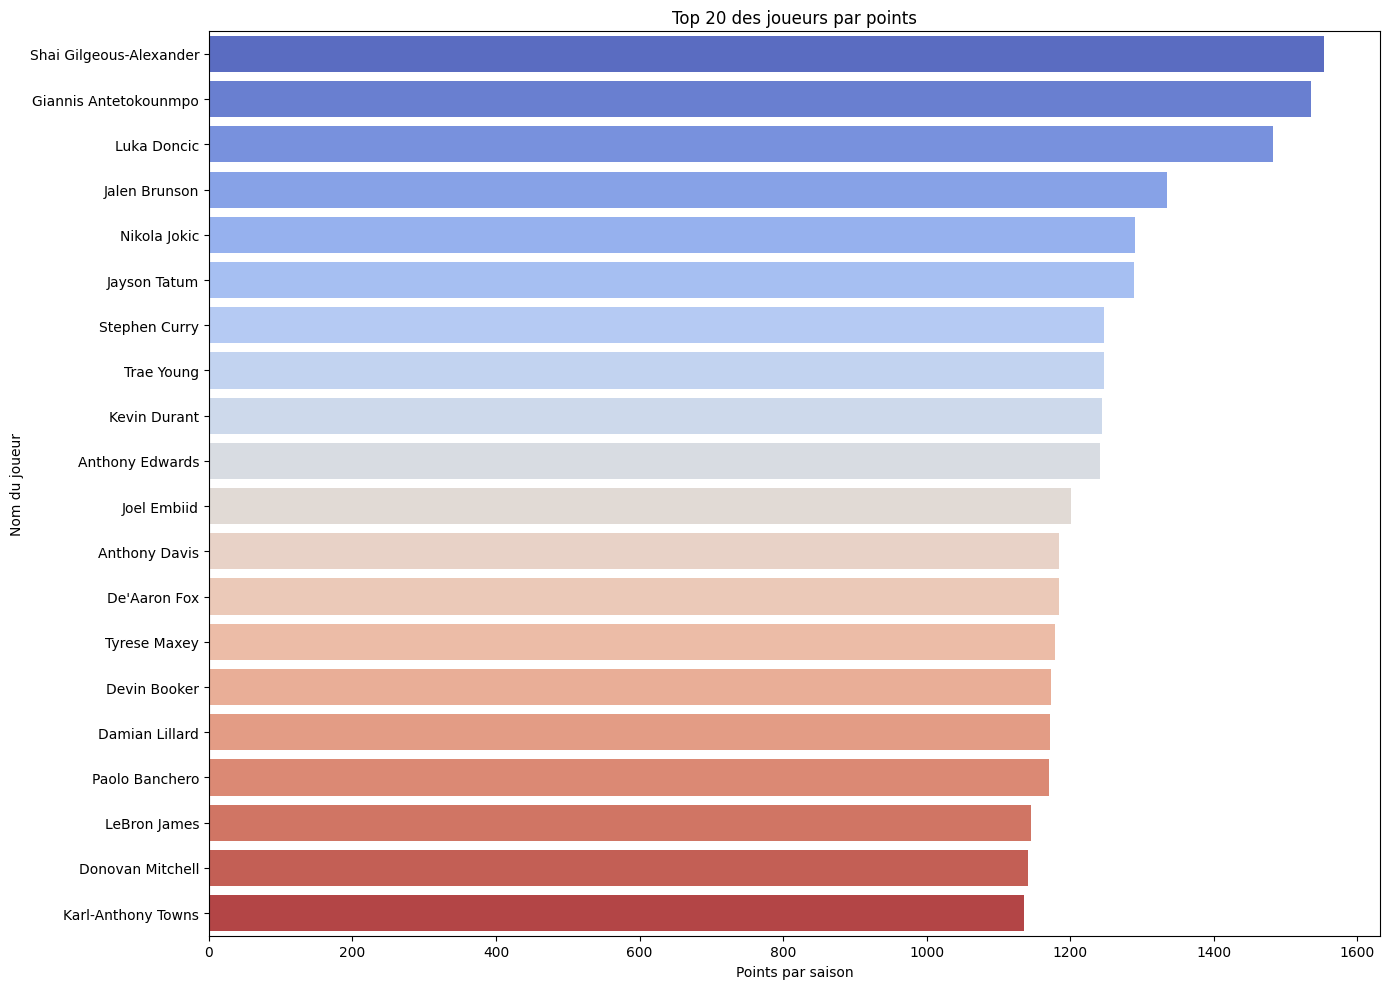

In [26]:
# Tri des joueurs par points marqués en ordre décroissant
top_players_by_points = players_stats_2023_24.sort_values('PTS', ascending=False).head(20)

# Création du graphique en barre
plt.figure(figsize=(14, 10))
sns.barplot(x='PTS', y='full_name', data=top_players_by_points, palette='coolwarm')
plt.title('Top 20 des joueurs par points')
plt.xlabel('Points par saison')
plt.ylabel('Nom du joueur')
plt.tight_layout()  # Ajuste automatiquement les paramètres de la figure pour donner plus d'espace

# Afficher le graphique
plt.show()
# Sorting the DataFrame by the 'AST' column to find the top 20 players by assists per game.
top_players_by_assists = players_stats_2023_24.sort_values('AST', ascending=False).head(20)

C:\Users\33624\AppData\Local\Temp\ipykernel_105208\2428979091.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='FG3M', y='full_name', data=top_3pt_scorers, palette='Blues_r')


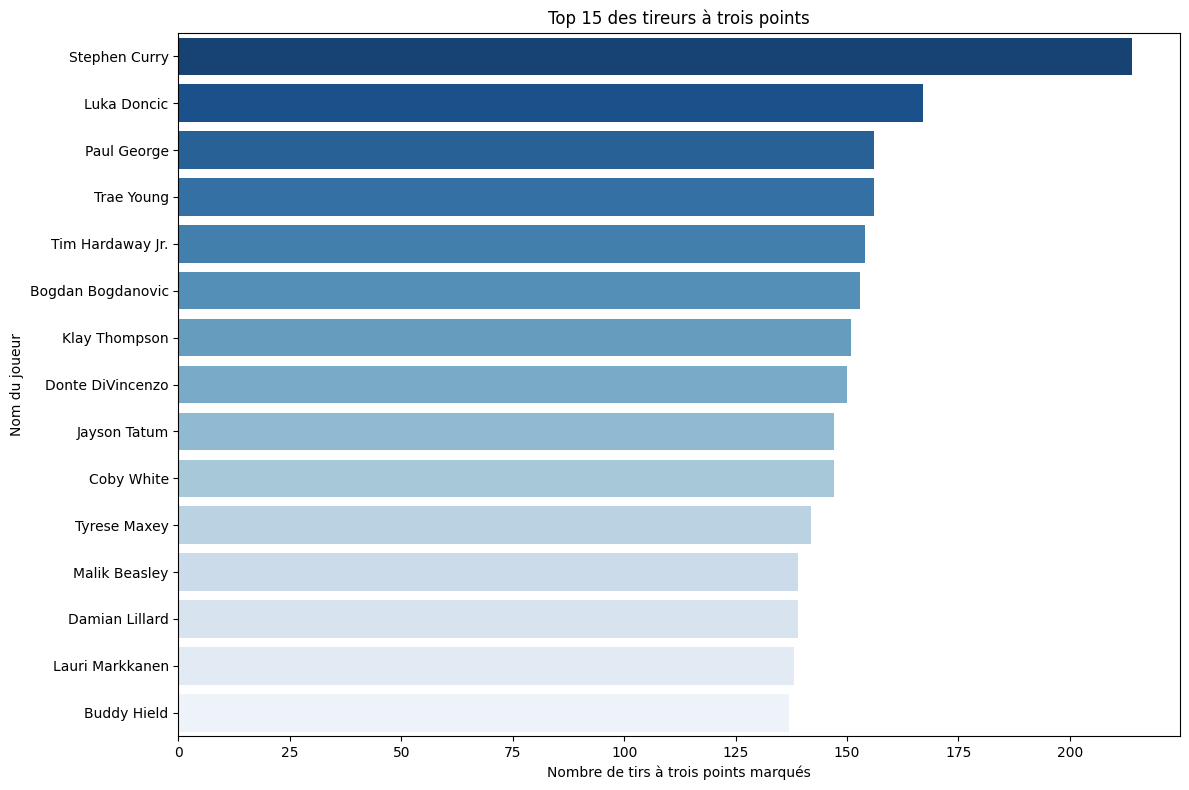

In [27]:
# Convertissons la colonne 'FG3M' en numérique, en forçant les erreurs en NaN et en remplaçant par 0
players_stats_2023_24['FG3M'] = pd.to_numeric(players_stats_2023_24['FG3M'], errors='coerce').fillna(0)

# Trouvons les 15 meilleurs tireurs à trois points (dans cet exemple, nous avons seulement 3 joueurs)
top_3pt_scorers = players_stats_2023_24.nlargest(15, 'FG3M')

# Créons le graphique en barres pour les meilleurs tireurs à trois points
plt.figure(figsize=(12, 8))
sns.barplot(x='FG3M', y='full_name', data=top_3pt_scorers, palette='Blues_r')
plt.title('Top 15 des tireurs à trois points')
plt.xlabel('Nombre de tirs à trois points marqués')
plt.ylabel('Nom du joueur')
plt.tight_layout()

# Affichons le graphique
plt.show()

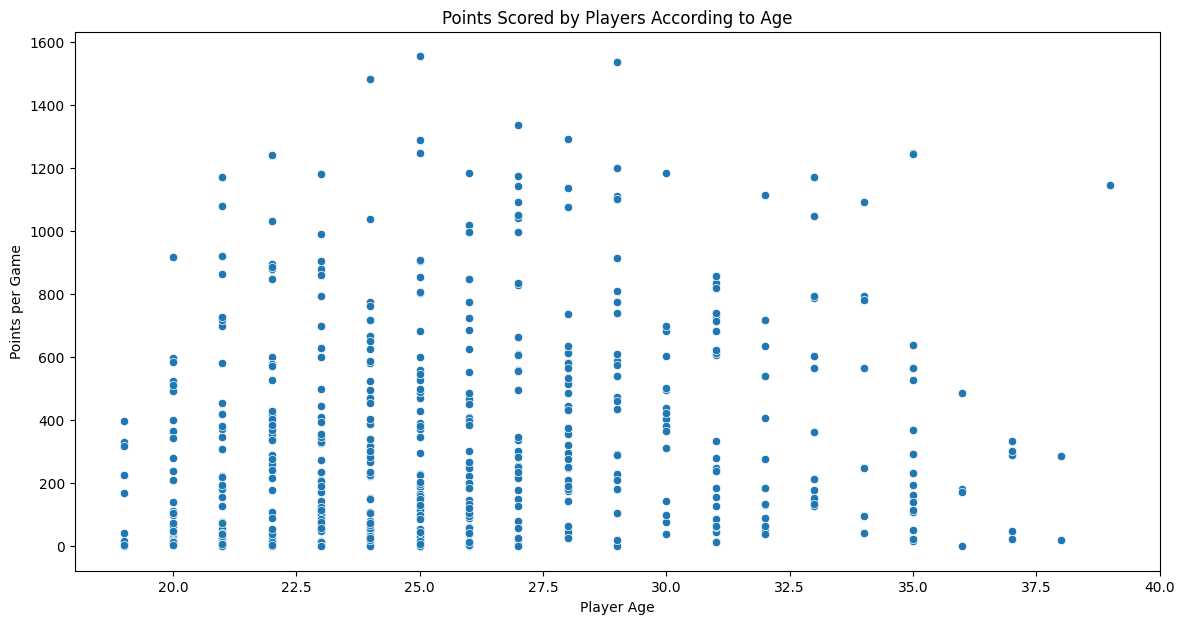

In [28]:

plt.figure(figsize=(14, 7))
sns.scatterplot(x='PLAYER_AGE', y='PTS', data=players_stats_2023_24)
plt.title('Points Scored by Players According to Age')
plt.xlabel('Player Age')
plt.ylabel('Points per Game')
plt.show()


C:\Users\33624\AppData\Local\Temp\ipykernel_105208\1106346530.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='GP', y='full_name', data=top_players_by_games_played, palette='viridis')


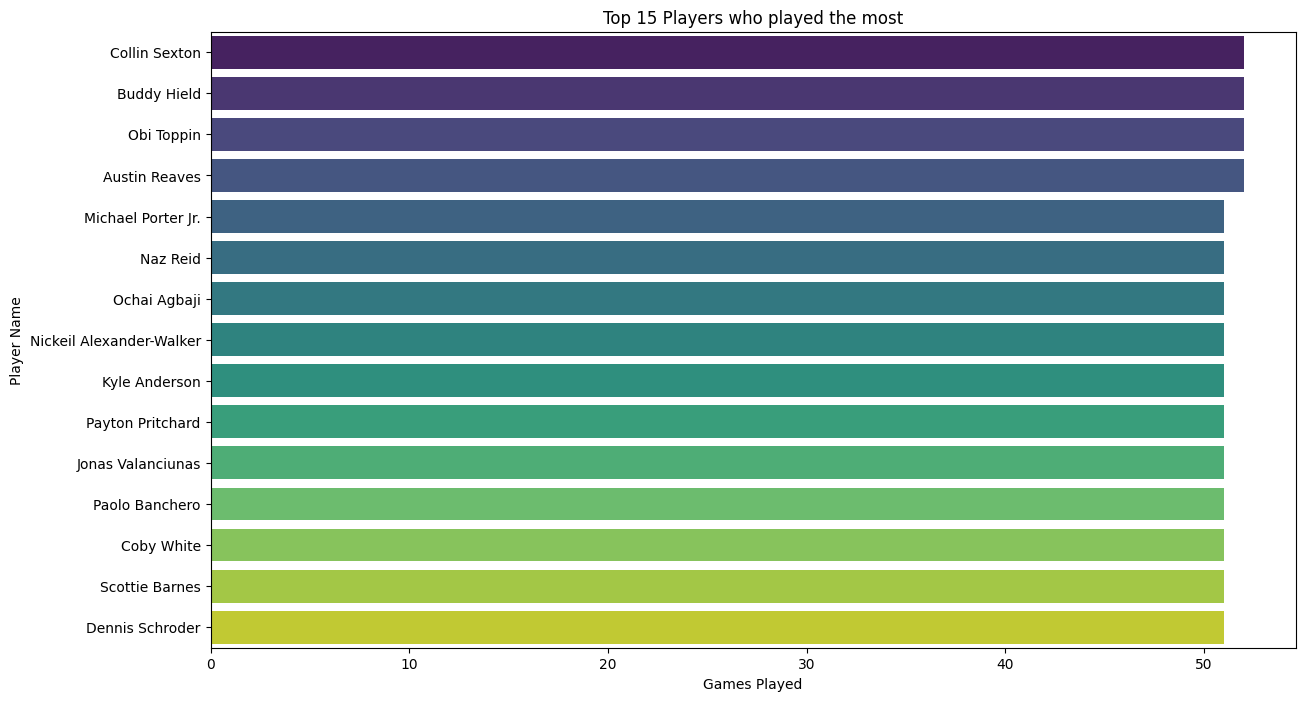

In [29]:

# Sort the DataFrame by the 'GP' column to find the players with the most games played.
top_players_by_games_played = players_stats_2023_24.sort_values('GP', ascending=False).head(15)

# Plotting the bar chart
plt.figure(figsize=(14, 8))
sns.barplot(x='GP', y='full_name', data=top_players_by_games_played, palette='viridis')
plt.title('Top 15 Players who played the most')
plt.xlabel('Games Played')
plt.ylabel('Player Name')
plt.show()


C:\Users\33624\AppData\Local\Temp\ipykernel_105208\3549325078.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='AST', y='full_name', data=top_players_by_assists, palette='coolwarm')


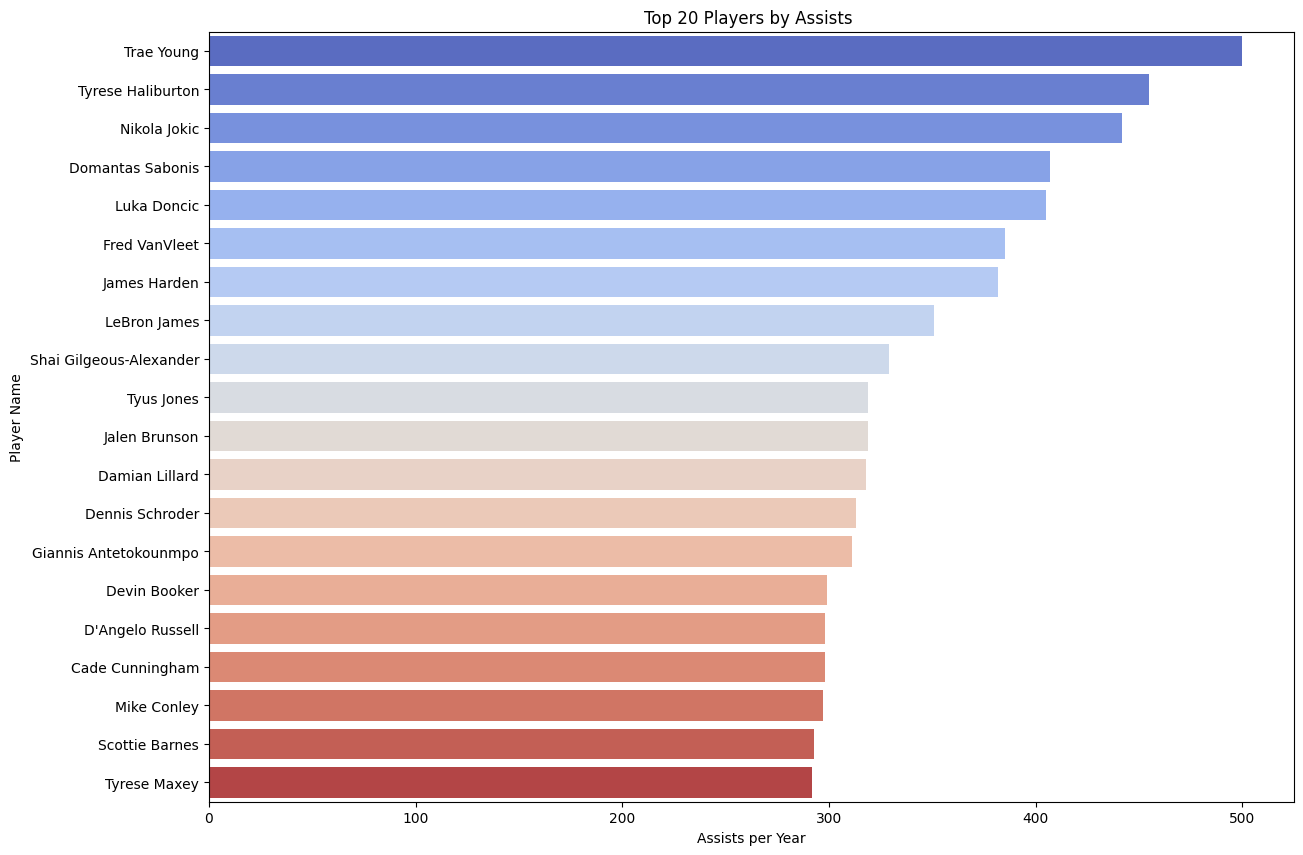

In [30]:
# Plotting the bar chart for the top 20 players by assists per game
plt.figure(figsize=(14, 10))
sns.barplot(x='AST', y='full_name', data=top_players_by_assists, palette='coolwarm')
plt.title('Top 20 Players by Assists ')
plt.xlabel('Assists per Year')
plt.ylabel('Player Name')
plt.show()
players_stats_2023_24['PPM'] = players_stats_2023_24['PTS'] / players_stats_2023_24['MIN'].replace({0: 1})


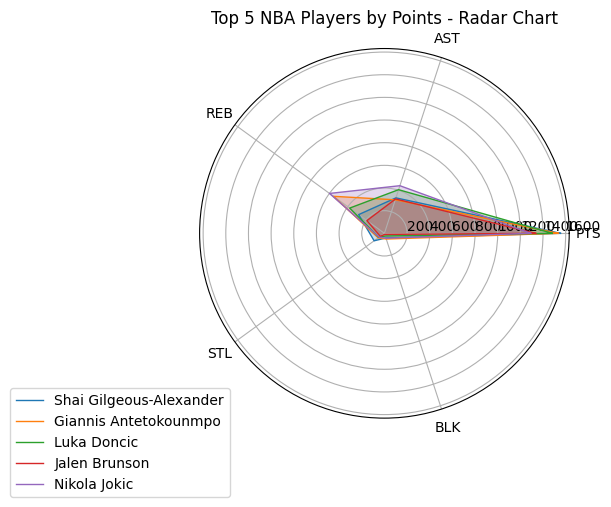

In [31]:
from math import pi
# Assuming the DataFrame 'players_stats_2023_24' is already sorted by 'PTS'
# Select the top 5 players by points scored
top_scorers = players_stats_2023_24.sort_values('PTS', ascending=False).head(5)
# Define the number of variables
categories = ['PTS', 'AST', 'REB', 'STL', 'BLK']
N = len(categories)

# Create a list of angles for the radar chart, one for each category
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Close the loop

# Initialize the radar plot
fig, ax = plt.subplots(subplot_kw={'polar': True})

# Draw one axe per variable and add labels
plt.xticks(angles[:-1], categories)

# Draw ylabels
ax.set_rlabel_position(0)

# Plot data and fill with color for each player
for i, row in top_scorers.iterrows():
    data = row[categories].tolist()
    data += data[:1]  # Repeat the first value to close the circle
    ax.plot(angles, data, linewidth=1, linestyle='solid', label=row['full_name'])
    ax.fill(angles, data, alpha=0.25)

# Add a legend and title
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Top 5 NBA Players by Points - Radar Chart')

# Show plot
plt.show()
### Data Vizualisation NBA teams


#

## 2. Analyse des Équipes

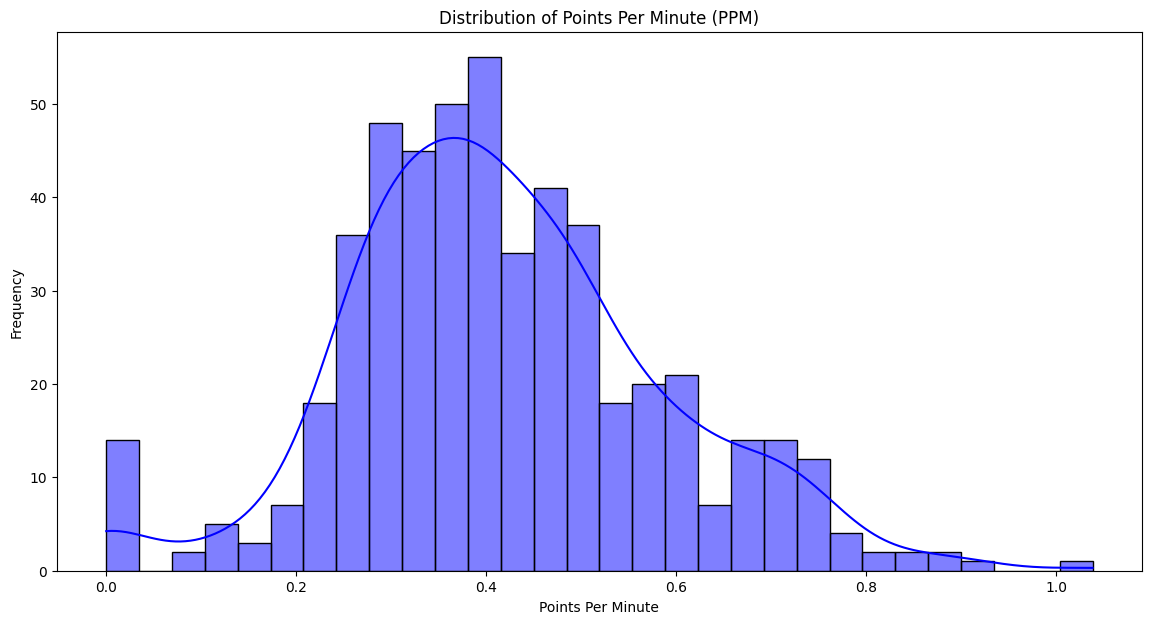

In [32]:
# Plotting the distribution of Points Per Minute (PPM) across all players
plt.figure(figsize=(14, 7))
sns.histplot(players_stats_2023_24['PPM'], bins=30, kde=True, color='blue')
plt.title('Distribution of Points Per Minute (PPM)')
plt.xlabel('Points Per Minute')
plt.ylabel('Frequency')
plt.show()


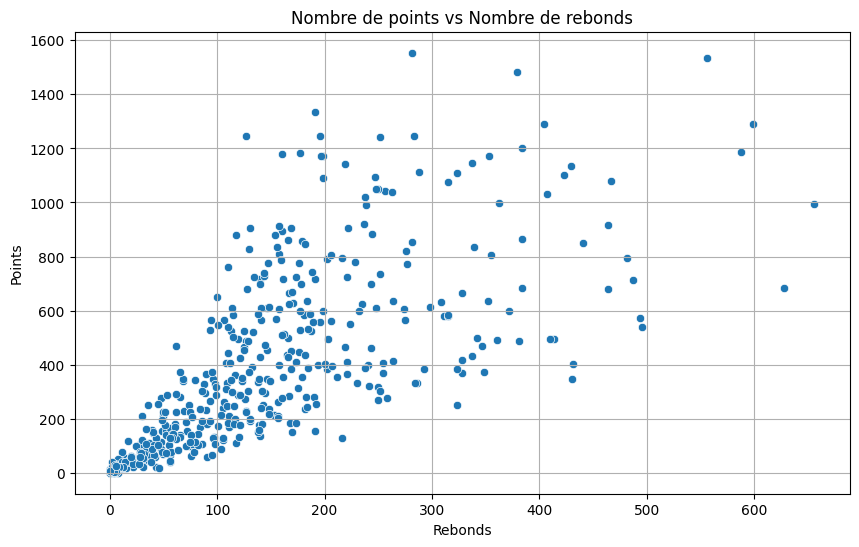

In [33]:
# Créer le nuage de points
plt.figure(figsize=(10, 6))
sns.scatterplot(x='REB', y='PTS', data=players_stats_2023_24)
plt.title('Nombre de points vs Nombre de rebonds')
plt.xlabel('Rebonds')
plt.ylabel('Points')
plt.grid(True)  # Ajouter une grille pour une meilleure lisibilité
plt.show()

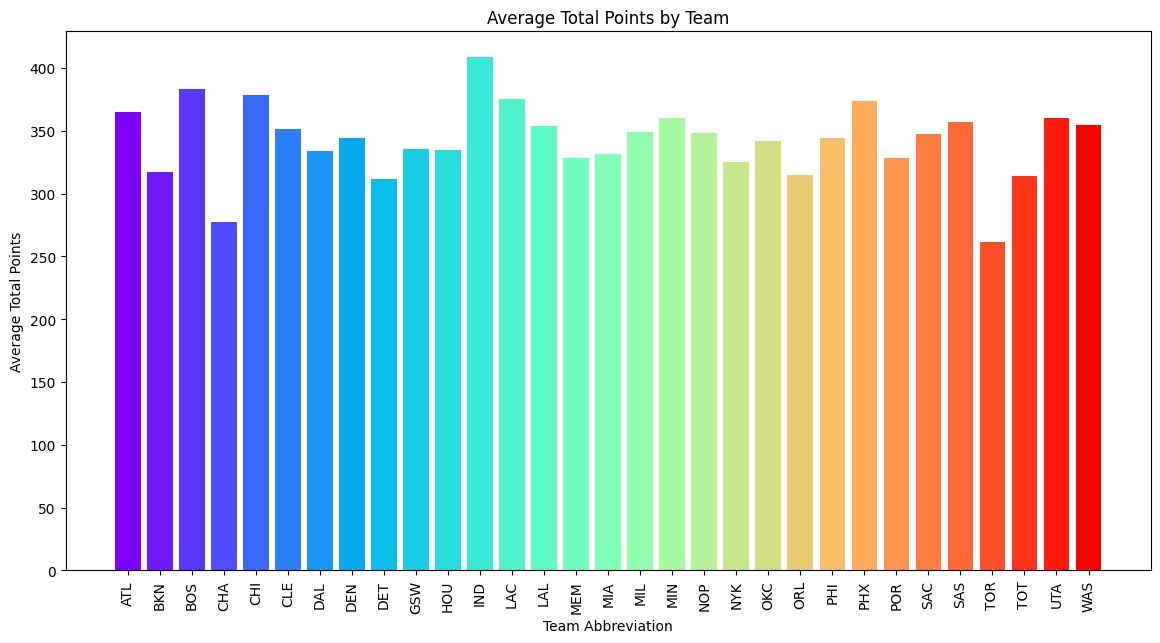

In [34]:
# Calculer la moyenne des points totaux par équipe
team_avg_points = players_stats_2023_24.groupby('TEAM_ABBREVIATION')['PTS'].mean().reset_index()

# Trier les données par équipe pour un affichage cohérent
team_avg_points = team_avg_points.sort_values('TEAM_ABBREVIATION')

# Création du graphique à barres
plt.figure(figsize=(14, 7))  # Ajustez la taille si nécessaire
plt.bar(team_avg_points['TEAM_ABBREVIATION'], team_avg_points['PTS'], color=plt.cm.rainbow(np.linspace(0, 1, len(team_avg_points))))

# Ajout de titres et d'étiquettes
plt.title('Average Total Points by Team')
plt.xlabel('Team Abbreviation')
plt.ylabel('Average Total Points')
plt.xticks(rotation=90)  # Rotation des étiquettes de l'axe des x pour une meilleure lisibilité

# Affichage du graphique
plt.show()

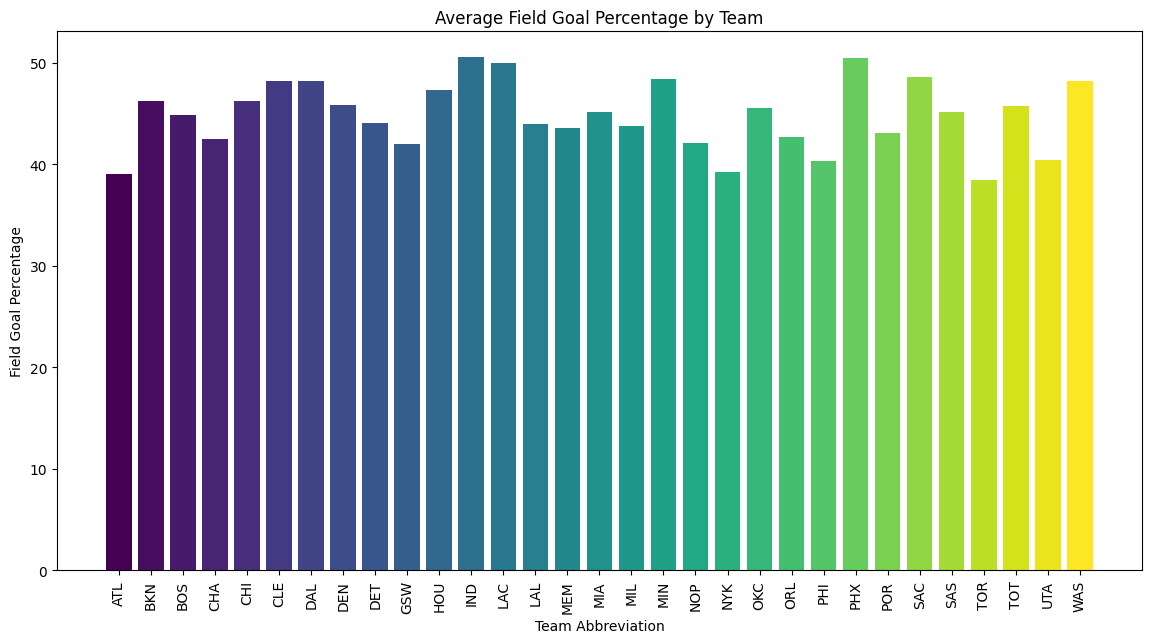

In [35]:
# Calculer le pourcentage moyen de réussite aux tirs par équipe
team_field_goal_pct = players_stats_2023_24.groupby('TEAM_ABBREVIATION')['FG_PCT'].mean().reset_index()

# Assurez-vous que le pourcentage est exprimé en pourcentage et non en décimal
team_field_goal_pct['FG_PCT'] *= 100

# Trier les données par équipe pour un affichage cohérent
team_field_goal_pct.sort_values('TEAM_ABBREVIATION', inplace=True)

# Créer un graphique à barres avec des couleurs arc-en-ciel pour chaque barre
plt.figure(figsize=(14, 7))  # Ajustez la taille si nécessaire
bar_colors = plt.cm.viridis(np.linspace(0, 1, len(team_field_goal_pct)))
plt.bar(team_field_goal_pct['TEAM_ABBREVIATION'], team_field_goal_pct['FG_PCT'], color=bar_colors)

# Ajouter des titres et des étiquettes
plt.title('Average Field Goal Percentage by Team')
plt.xlabel('Team Abbreviation')
plt.ylabel('Field Goal Percentage')
plt.xticks(rotation=90)  # Rotation des étiquettes de l'axe des x pour une meilleure lisibilité

# Afficher le graphique
plt.show()

heatmap victoire ce qui influence

# Get team stats of each game

In [60]:
from nba_api.stats.endpoints import teamgamelogs

# Query for games where the Celtics were playing
stat_team_game = teamgamelogs.TeamGameLogs(season_nullable= "2023-24")
# The first DataFrame of those returned is what we want.
stat_team_game = stat_team_game.get_data_frames()[0]
stat_team_game  

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,AVAILABLE_FLAG
0,2023-24,1610612737,ATL,Atlanta Hawks,0022300729,2024-02-07T00:00:00,ATL @ BOS,L,48.0,43,...,980,121,505,1299,1354,53,1162,661,1050,1
1,2023-24,1610612761,TOR,Toronto Raptors,0022300726,2024-02-07T00:00:00,TOR @ CHA,W,48.0,43,...,329,317,1132,1095,85,360,579,416,522,1
2,2023-24,1610612755,PHI,Philadelphia 76ers,0022300727,2024-02-07T00:00:00,PHI vs. GSW,L,48.0,41,...,1278,932,695,168,1238,256,441,1220,1417,1
3,2023-24,1610612739,CLE,Cleveland Cavaliers,0022300728,2024-02-07T00:00:00,CLE @ WAS,W,48.0,43,...,874,759,1287,628,674,9,237,792,427,1
4,2023-24,1610612740,NOP,New Orleans Pelicans,0022300731,2024-02-07T00:00:00,NOP @ LAC,W,48.0,47,...,329,932,35,628,85,360,1027,661,323,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,2023-24,1610612752,NYK,New York Knicks,0022300065,2023-10-25T00:00:00,NYK vs. BOS,L,48.0,36,...,980,317,331,1504,1483,1081,326,1220,869,1
1516,2023-24,1610612747,LAL,Los Angeles Lakers,0022300061,2023-10-24T00:00:00,LAL @ DEN,L,48.0,41,...,1092,478,1132,849,894,495,1266,1104,1199,1
1517,2023-24,1610612756,PHX,Phoenix Suns,0022300062,2023-10-24T00:00:00,PHX @ GSW,W,48.0,42,...,1092,1362,1132,284,894,1081,237,1063,618,1
1518,2023-24,1610612744,GSW,Golden State Warriors,0022300062,2023-10-24T00:00:00,GSW vs. PHX,L,48.0,36,...,1418,317,118,430,1092,1196,326,1220,869,1


In [37]:
stat_team_game.drop("SEASON_YEAR", axis=1, inplace=True)
stat_team_game.drop("MIN", axis=1, inplace=True)

In [38]:
stat_team_game.columns

Index(['TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE',
       'MATCHUP', 'WL', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
       'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL',
       'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS', 'GP_RANK', 'W_RANK',
       'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'FGM_RANK', 'FGA_RANK',
       'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK', 'FTM_RANK',
       'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK', 'DREB_RANK', 'REB_RANK',
       'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK', 'BLKA_RANK', 'PF_RANK',
       'PFD_RANK', 'PTS_RANK', 'PLUS_MINUS_RANK', 'AVAILABLE_FLAG'],
      dtype='object')

In [ ]:
df.head()

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Format de la date actuelle pour correspondre au format du nom de fichier
today = datetime.now().strftime("%Y-%m-%d")

# Chemin du fichier CSV contenant les statistiques des matchs NBA
file_path_game_stats = f'../dataset/nba_games_stats_{today}.csv'

# Chargement des données depuis le fichier CSV
df = pd.read_csv(file_path_game_stats)

# Numérisation de la colonne 'WL'
df['WL_numeric'] = df['WL'].map({'W': 1, 'L': 0})

# Sélectionner uniquement les colonnes numériques pour la matrice de corrélation
# Y compris la nouvelle colonne 'WL_numeric'
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
numeric_columns.append('WL_numeric')  # Ajouter la colonne numérisée 'WL'

# Calculer la matrice de corrélation pour les colonnes numériques
correlation_matrix = df[numeric_columns].corr()


In [13]:

# Obtenir les 10 caractéristiques les plus importantes en relation avec 'WL_numeric'
# Utiliser nlargest pour éviter l'erreur avec sort_values
important_features = correlation_matrix['WL_numeric'].nlargest(11)

# Affichage des caractéristiques les plus importantes
print("Caractéristiques les plus importantes en corrélation avec le résultat du match (victoire ou défaite) :")
print(important_features)

# Création d'un histogramme pour les caractéristiques importantes en corrélation avec 'WL_numeric'
plt.figure(figsize=(10, 6))
sns.barplot(x=important_features.index, y=important_features.values, palette='viridis')
plt.xticks(rotation=45)
plt.title('Top 10 des Caractéristiques en Corrélation avec la Victoire')
plt.xlabel('Caractéristiques')
plt.ylabel('Coefficient de Corrélation')
plt.tight_layout()  # Ajuster la disposition
plt.show()


TypeError: DataFrame.nlargest() missing 1 required positional argument: 'columns'

In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import os

# Format de la date pour correspondre au format de votre fichier
today = datetime.now().strftime("%Y-%m-%d")

# Chemin du dossier où se trouve le fichier CSV
data_folder_path = '../dataset/'

# Création du dossier s'il n'existe pas
if not os.path.exists(data_folder_path):
    os.makedirs(data_folder_path)

# Chemin complet vers le fichier CSV
file_path_game_stats = f'{data_folder_path}nba_games_stats_{today}.csv'

# Vérification de l'existence du fichier avant de le charger
if os.path.isfile(file_path_game_stats):
    # Chargement des données depuis le fichier CSV
    df = pd.read_csv(file_path_game_stats)

    # Suite du code pour la numérisation et la création de la matrice de corrélation...
else:
    print(f"Le fichier {file_path_game_stats} n'existe pas. Vérifiez le nom du fichier et le dossier.")


In [72]:
file_path_game_stats = f'../dataset/nba_games_stats_{today}.csv'

stat_team_game.to_csv(file_path_game_stats, index=False) #the file will be overwrite if already existing 

In [73]:
stat_team_game['GAME_DATE'] = pd.to_datetime(stat_team_game['GAME_DATE'])

col_type = stat_team_game["GAME_DATE"].dtypes
print(col_type)

datetime64[ns]


In [41]:
stat_team_game.dtypes

TEAM_ID                       int64
TEAM_ABBREVIATION            object
TEAM_NAME                    object
GAME_ID                      object
GAME_DATE            datetime64[ns]
MATCHUP                      object
WL                           object
FGM                           int64
FGA                           int64
FG_PCT                      float64
FG3M                          int64
FG3A                          int64
FG3_PCT                     float64
FTM                           int64
FTA                           int64
FT_PCT                      float64
OREB                          int64
DREB                          int64
REB                           int64
AST                           int64
TOV                         float64
STL                           int64
BLK                           int64
BLKA                          int64
PF                            int64
PFD                           int64
PTS                           int64
PLUS_MINUS                  

## Create target column Win/Lose

In [42]:
stat_team_game['Win/Lose'] = np.where(stat_team_game['WL'] == 'W', 1, 0)
stat_team_game.drop("WL", axis = 1, inplace=True)
stat_team_game.drop("TEAM_ID", axis = 1, inplace=True)
stat_team_game.drop("TEAM_NAME", axis = 1, inplace=True)
stat_team_game.drop("GAME_ID", axis = 1, inplace=True)

stat_team_game.head()

,TEAM_ABBREVIATION,GAME_DATE,MATCHUP,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,...,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,AVAILABLE_FLAG,Win/Lose
0,PHI,2024-02-07,PHI vs. GSW,41,98,0.418,8,32,0.250,14,...,932,695,168,1238,256,441,1220,1417,1,0
1,DET,2024-02-07,DET @ SAC,47,84,0.560,17,31,0.548,22,...,615,1479,1299,894,943,579,121,267,1,1
2,CHA,2024-02-07,CHA vs. TOR,44,90,0.489,16,39,0.410,13,...,202,916,1299,223,792,1027,661,948,1,0
3,BOS,2024-02-07,BOS vs. ATL,49,93,0.527,17,49,0.347,10,...,759,916,88,85,256,1419,344,427,1,1
4,ATL,2024-02-07,ATL @ BOS,43,102,0.422,13,41,0.317,18,...,121,505,1299,1354,53,1162,661,1050,1,0


In [43]:
player_stats.dtypes

SEASON_ID             object
Player_ID             object
Game_ID               object
GAME_DATE     datetime64[ns]
MATCHUP               object
WL                    object
MIN                   object
FGM                   object
FGA                   object
FG_PCT               float64
FG3M                  object
FG3A                  object
FG3_PCT              float64
FTM                   object
FTA                   object
FT_PCT               float64
OREB                  object
DREB                  object
REB                   object
AST                   object
STL                   object
BLK                   object
TOV                   object
PF                    object
PTS                   object
PLUS_MINUS            object
dtype: object

In [44]:
player_stats.head(10)

,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS
0,22023,1630173,0022300722,2024-02-06,NYK vs. MEM,W,40,8,13,0.615,...,2,3,5,3,3,1,0,2,17,-1
1,22023,1630173,0022300701,2024-02-03,NYK vs. LAL,L,42,4,11,0.364,...,4,4,8,0,0,1,1,2,10,-10
2,22023,1630173,0022300685,2024-02-01,NYK vs. IND,W,43,5,16,0.313,...,8,8,16,0,4,2,2,4,12,7
3,22023,1630173,0022300671,2024-01-30,NYK vs. UTA,W,40,8,13,0.615,...,1,4,5,1,0,2,0,3,18,14
4,22023,1630173,0022300657,2024-01-29,NYK @ CHA,W,33,4,6,0.667,...,1,4,5,0,0,1,0,4,9,21
5,22023,1630173,0022300643,2024-01-27,NYK vs. MIA,W,31,2,7,0.286,...,3,7,10,1,1,2,0,2,4,19
6,22023,1630173,0022300631,2024-01-25,NYK vs. DEN,W,23,1,4,0.250,...,6,4,10,3,0,1,0,1,2,18
7,22023,1630173,0022300615,2024-01-23,NYK @ BKN,W,21,3,6,0.500,...,4,5,9,2,0,0,0,1,6,13
8,22023,1630173,0022300596,2024-01-20,NYK vs. TOR,W,25,9,10,0.900,...,4,7,11,0,0,1,3,4,18,13
9,22023,1630173,0022300579,2024-01-18,NYK vs. WAS,W,9,1,1,1.000,...,0,1,1,0,1,0,0,1,2,-4


## Split the dataset into Train/Test

In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming 'df' is your DataFrame containing the data
# Drop the columns with high correlation
# Use the 'errors' parameter to 'ignore' non-existing columns
df = df.drop(columns=[
    'Player_Name', 'Position', 'Team_Abbreviation', 'Field_Goals_Made', 
    'Field_Goals_Attempted', 'Three_Point_FG_Made', 'Three_Point_FG_Attempted', 
    'Three_Point_FG_Percentage', 'NBA_Fantasy_Points', 'Double_Doubles', 
    'Free_Throws_Attempted', 'Triple_Doubles', 'Offensive_Rebounds', 
    'Defensive_Rebounds'
], errors='ignore')

# Define your features (X) and target (y)
X = df.drop('PTS', axis=1)
y = df['PTS']

# Split the dataset into training and testing sets
# 80% for training and 20% for testing, and a random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the dimensions of the training and testing data
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')


NameError: name 'df' is not defined

## Modeling: Linear Regression


On crée un modèle de régression linéaire, testant diverses tailles de tests et états aléatoires pour trouver les meilleurs paramètres. On entraîne le modèle sur des données d'entraînement et on évalue la performance avec le score R², en mettant à jour les meilleurs paramètres à chaque itération. Enfin, on affiche la meilleure taille de test, l'état aléatoire optimal et le meilleur score R² obtenu.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

# Assumons que 'df' est votre DataFrame et que 'PTS' est la variable cible
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
if 'PTS' in categorical_columns:
    categorical_columns.remove('PTS')  # Assurez-vous que la variable cible n'est pas incluse

# Définissez le ColumnTransformer pour appliquer OneHotEncoding aux colonnes catégorielles
column_transformer = ColumnTransformer(
    transformers=[
        ('category_encoder', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ],
    remainder='passthrough'  # Laissez les autres colonnes inchangées
)

# Appliquez le transformateur au DataFrame moins la variable cible
X = column_transformer.fit_transform(df.drop('PTS', axis=1))
y = df['PTS'].values  # Assurez-vous que 'PTS' est une colonne numérique

# Définissez les tailles de test et les états aléatoires à parcourir
test_sizes = [0.15, 0.2, 0.25, 0.3]
random_states = [0, 1, 42, 43, 100, 313]

# Initialisez les variables pour stocker la meilleure taille de test, l'état aléatoire et le score R2
best_test_size = None
best_random_state = None
best_r2_score = -np.inf

# Itérez à travers toutes les combinaisons de tailles de test et d'états aléatoires
for test_size in test_sizes:
    for random_state in random_states:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        if r2 > best_r2_score:
            best_r2_score = r2
            best_test_size = test_size
            best_random_state = random_state

# Imprimez la meilleure taille de test, l'état aléatoire et le score R2
print(f'Best test size: {best_test_size}')
print(f'Best random state: {best_random_state}')
print(f'Best R2 score: {best_r2_score}')


Best test size: 0.25
Best random state: 100
Best R2 score: 0.8992859654777237


## Linear Regression Model Training and Evaluation


The linear regression model is trained on a subset of data, holding back 20% as a test set to evaluate its predictions. After training, the model's accuracy is quantified using the R2 score, reflecting how well it forecasts the test data based on learned patterns from the training data.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Assuming 'categorical_columns' is the list of your categorical columns
column_transformer = ColumnTransformer(
    transformers=[
        ('category_encoder', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ],
    remainder='passthrough'
)

# Apply the transformer to the DataFrame
X_train_transformed = column_transformer.fit_transform(X_train)
X_test_transformed = column_transformer.transform(X_test)

# Now you can fit and predict with the model without the ValueError
model.fit(X_train_transformed, y_train)
y_pred = model.predict(X_test_transformed)
r2 = r2_score(y_test, y_pred)
print(r2)


0.8517916513406278


## Test size Tuning for Decision Tree Regressor


L'ajustement des hyperparamètres pour un modèle de régression d'arbre de décision est effectué à l'aide d'une approche de recherche en grille, visant à optimiser les hyperparamètres pour maximiser le score R2. Après avoir testé diverses tailles de jeu de test et états aléatoires, le processus révèle la meilleure taille de jeu de test, l'état aléatoire et le score R2, illustrant ainsi la performance prédictive optimale du modèle.

In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split



# Sélectionnez les colonnes numériques et catégorielles
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Assurez-vous que la colonne cible 'PTS' n'est pas dans les caractéristiques numériques
numeric_features.remove('PTS')

# Définir le transformateur de colonne pour les caractéristiques numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Préparez les caractéristiques et la cible
X = df.drop('PTS', axis=1)
y = df['PTS']

# Initialisation des variables pour enregistrer les meilleurs paramètres
best_test_size = None
best_random_state = None
best_r2_score = -float('inf')

# Définition des tailles de test et des états aléatoires à tester
test_sizes = [0.1, 0.15, 0.2, 0.3]
random_states = [0, 1, 42, 43, 100, 313]

# Parcours de toutes les tailles de test et des états aléatoires
for test_size in test_sizes:
    for random_state in random_states:
        # Séparation des données en ensembles d'entraînement et de test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

        # Transformation des ensembles d'entraînement et de test
        X_train_transformed = preprocessor.fit_transform(X_train)
        X_test_transformed = preprocessor.transform(X_test)

        # Entraînement du modèle Decision Tree Regressor
        model = DecisionTreeRegressor()
        model.fit(X_train_transformed, y_train)

        # Prédiction sur l'ensemble de test transformé
        y_pred = model.predict(X_test_transformed)

        # Calcul du score R2
        r2 = r2_score(y_test, y_pred)

        # Mise à jour des meilleurs paramètres si le score R2 actuel est meilleur
        if r2 > best_r2_score:
            best_r2_score = r2
            best_test_size = test_size
            best_random_state = random_state

# Affichage des meilleurs paramètres
print(f'Best test size: {best_test_size}')
print(f'Best random state: {best_random_state}')
print(f'Best R2 score: {best_r2_score}')


Best test size: 0.15
Best random state: 100
Best R2 score: 0.8835263007784654


In [ ]:
# Check if 'PTS' column exists in the DataFrame
if 'PTS' not in df.columns:
    raise ValueError("Column 'PTS' does not exist in the DataFrame. Please check the column names with df.columns.")

# If 'PTS' column exists, proceed with the previous code
# ...


In [ ]:
# Exemple hypothétique basé sur la structure de l'API
season_2023_24_stats = career.season_totals_regular_season.get_data_frame()[career.season_totals_regular_season.get_data_frame()['SEASON_ID'] == '2023-24']

NameError: name 'career' is not defined

In [ ]:
type(season_2023_24_stats)

NameError: name 'season_2023_24_stats' is not defined

In [ ]:
season_2023_24_stats.head(10)

NameError: name 'season_2023_24_stats' is not defined

In [ ]:
assert sum(players.isnull().sum()) == 0, "There are not null values in the dataset"


AttributeError: module 'nba_api.stats.static.players' has no attribute 'isnull'

In [ ]:
players["EFF"] = players.PTS + players.TRB + players.AST + players.STL + players.BLK - (players.FGA - players.FG) - (players.FTA - players.FT) - players.TOV

AttributeError: module 'nba_api.stats.static.players' has no attribute 'PTS'

In [ ]:
plt.figure(figsize=(14,6))
sns.swarmplot(
    x=players["Pos"],
    y=players["EFF"]
)

: 

In [ ]:
ages = players.Age.describe().round(decimals=1) # used to specify the first 25%, defining what is a young player
points = players.PTS.describe().round(decimals=1)

AttributeError: module 'nba_api.stats.static.players' has no attribute 'Age'

In [ ]:
sns.boxplot(data=players, y="PTS");

: 

In [ ]:
plt.figure(figsize=(14,6))
sns.boxplot(data=players, x="Age", y="PTS");

: 

With the graph below, we can see that within <23y (what we have defined to be a young age), if we have more than 15 points we are special. Those data will then be used to filter the current base player and keep only special ones.

In [ ]:
young_age = ages["25%"]
futur_super_star_def = f"(EFF >= 12) & (PTS >= 15) & (Age <= {young_age})"
players.query(futur_super_star_def).sort_values("EFF", ascending=False).sort_values(["Age", "EFF"], ascending=True)

NameError: name 'ages' is not defined